In [1]:
# Neural Style Transfer
# it allows us to take an image and reproduce it with a new artistic style.
# the algorithm takes three images, an input image, a content-image, and a style-image,
# and changes the input to resemble the content of the content-image and the artistic style of the style-image.

In [2]:
# Underlying Principle
# we define two distances, one for the content (DC) and one for the style (DS) : 
    # DC: measures how different the content is between two images
    # DS: measures how different the style is between two images. 
# Then, we take a third image, the input, and transform it to minimize both its content-distance with the content-image and its style-distance with the style-image.

In [3]:
# Importing the packages
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [4]:
# Selecting the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Loading the Images
# Now we will import the style and content images. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1.
# The images also need to be resized to have the same dimensions. 
# Neural networks from the torch library are trained with tensor values ranging from 0 to 1. If you try to feed the networks with 0 to 255 tensor images, then the activated feature maps will be unable sense the intended content and style.
# However, pre-trained networks from the Caffe library are trained with 0 to 255 tensor images.

# desired size of the input image
imsize = 512 if torch.cuda.is_available() else 128    # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),   # scale imported image
    transforms.ToTensor()        # transform it into a torch tensor
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)   # fake batch dimension required to fit network's input dimensions
    return image.to(device, torch.float)

style_img = image_loader('./images/picasso.jpg')
content_img = image_loader('./images/dancing.jpg')

assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

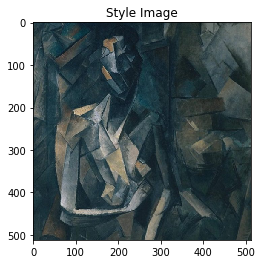

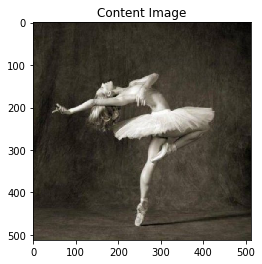

In [6]:
# a function that displays an image by reconverting a copy of it to PIL format and displaying the copy using plt.imshow.

unloader = transforms.ToPILImage()    # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()    # we clone the tensor to not do changes on it
    image = image.squeeze(0)    # remove fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)    # pause a bit so that plots are updated
    
plt.figure()
imshow(style_img, title="Style Image")

plt.figure()
imshow(content_img, title="Content Image")

In [7]:
# Content Loss
# represents a weighted version of the content distance for an individual layer.
# The function takes the feature maps F_XL of a layer L in a network processing input X and returns the weighted content distance w_CL*D_LC(X,C) between the image X and the content image C.
# The feature maps of the content image(F_CL) must be known by the function in order to calculate the content distance.
# We implement this function as a torch module with a constructor that takes F_CL as an input.
# The distance ∥F_XL−F_CL∥^2 is the mean square error between the two sets of feature maps, and can be computed using nn.MSELoss.

# We will add this content loss module directly after the convolution layer(s) that are being used to compute the content distance.
# This way each time the network is fed an input image the content losses will be computed at the desired layers and because of auto grad, all the gradients will be computed.
# Now, in order to make the content loss layer transparent we must define a forward method that computes the content loss and then returns the layer’s input.
# The computed loss is saved as a parameter of the module.

In [8]:
class ContentLoss(nn.Module):
    
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used to dynamically compute the gradient: 
        # this is a stated value, not a variable. Otherwise the forward method of the criterion will throw an error.
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [9]:
# Style Loss
# The style loss module is implemented similarly to the content loss module. 
# It will act as a transparent layer in a network that computes the style loss of that layer.
# In order to calculate the style loss, we need to compute the gram matrix G_XL.
# A gram matrix is the result of multiplying a given matrix by its transposed matrix.
# In this application the given matrix is a reshaped version of the feature maps F_XL of a layer L.
# F_XL is reshaped to form F^_XL, a KxN matrix, where K is the number of feature maps at layer L and N is the length of any vectorized feature map Fk_XL.
# For example, the first line of F^_XL corresponds to the first vectorized feature map F1_XL.

# the gram matrix must be normalized by dividing each element by the total number of elements in the matrix.
# This normalization is to counteract the fact that F^_XL matrices with a large N dimension yield larger values in the Gram matrix.
# These larger values will cause the first layers (before pooling layers) to have a larger impact during the gradient descent.
# Style features tend to be in the deeper layers of the network so this normalization step is crucial.

In [10]:
def gram_matrix(input):
    a, b, c, d =input.size()
    # a = batch size(=1)
    # b = number of feature maps
    # (c, d) = dimensions of a feature map (N=c*d)
    features = input.view(a*b, c*d)    # resize F_XL into hat F_XL
    
    G = torch.mm(features, features.t())   # compute the gram product
    
    # we 'normalize' the values of the gram matrix by dividing by the number of element in each feature maps.
    return G.div(a*b*c*d)

In [11]:
# Now the style loss module looks almost exactly like the content loss module.
# The style distance is also computed using the mean square error between G_XL and G_SL.

class StyleLoss(nn.Module):
    
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [12]:
# Importing the Model
# PyTorch’s implementation of VGG is a module divided into two child Sequential modules: 
    # features: containing convolution and pooling layers
    # classifier: containing fully connected layers
# We will use the features module because we need the output of the individual convolution layers to measure content and style loss.
# Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval().

cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [13]:
#  VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
# We will use them to normalize the image before sending it into the network.

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [c x 1 x 1] so that they can directly work with the image Tensor of shape [B x C x H x W].
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, img):
        # normalize img
        return (img-self.mean)/self.std

In [14]:
# A Sequential module contains an ordered list of child modules.
# For instance, vgg19.features contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth.
# We need to add our content loss and style loss layers immediately after the convolution layer they are detecting.
# To do this we must create a new Sequential module that has content loss and style loss modules correctly inserted.

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                              style_img, content_img,
                              content_layers=content_layers_default,
                              style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    style_losses = []
    content_losses = []
    
    model = nn.Sequential(normalization)
    
    # assuming that cnn is a nn.Sequential
    # so we make a new nn.Sequential to put in modules that are supposed to be activated sequentially.
    i = 0    # increment every time we  see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i+=1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            
        model.add_module(name, layer)
        
        if name in content_layers:
            # add content loss
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            # add style loss
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            
    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
            
    model = model[:(i+1)]
    
    return model, style_losses, content_losses 

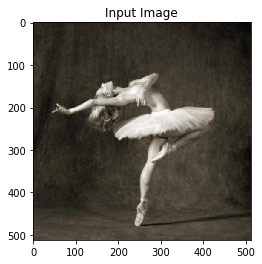

In [15]:
# select an input image. we can use a copy of the content image or white noise.

input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)

plt.figure()
imshow(input_img, title='Input Image')

In [16]:
# Gradient Descent
# Unlike training a network, we want to train the input image in order to minimize the content/style losses.
# We will create a PyTorch L-BFGS optimizer optim.LBFGS and pass our image to it as the tensor to optimize.

def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [17]:
# For each iteration of the networks, it is fed an updated input and computes new losses. 
# We will run the backward methods of each loss module to dynamicaly compute their gradients.
# The optimizer requires a “closure” function, which reevaluates the module and returns the loss.

def run_style_transfer(cnn, normalization_mean, normalization_std, 
                      content_img, style_img, input_img, num_steps=300,
                      content_weight=1, style_weight=1000000):
    print('Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    
    print('Optimizing...')
    
    run = [0]
    while run[0]<=num_steps:
        
        def closure():
            # correct the values of update input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            
            for sl in  style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
                
            style_score *= style_weight
            content_score *= content_weight
            
            loss = style_score + content_score
            loss.backward()
            
            run[0]+=1
            if run[0]%50 == 0:
                print("run {}".format(run))
                print('Style Loss : {:.4f} Content Loss : {:.4f}'.format(style_score.item(), content_score.item()))
                print()
                
            return style_score + content_score
        
        optimizer.step(closure)
        
    # a last correction...
    input_img.data.clamp_(0, 1)
    
    return input_img

Building the style transfer model...
Optimizing...
run [50]
Style Loss : 4.0207 Content Loss : 4.1785

run [100]
Style Loss : 1.1089 Content Loss : 3.0025

run [150]
Style Loss : 0.7010 Content Loss : 2.6507

run [200]
Style Loss : 0.4723 Content Loss : 2.4965

run [250]
Style Loss : 0.3434 Content Loss : 2.4109

run [300]
Style Loss : 0.2622 Content Loss : 2.3555



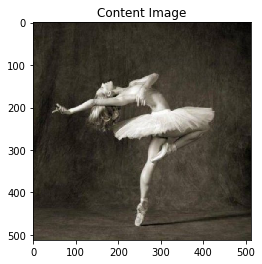

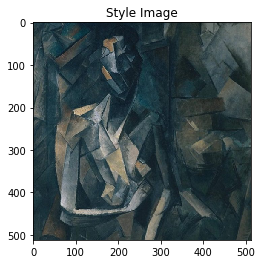

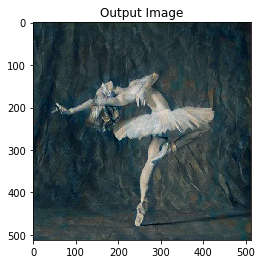

In [18]:
# run the algorithm

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

plt.figure()
imshow(content_img, title='Content Image')
imshow(style_img, title='Style Image')
imshow(output, title='Output Image')


plt.ioff()
plt.show()